<a href="https://colab.research.google.com/github/fahmiyansyah/Machine_Learning/blob/main/Machine_Learning_Quiz_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


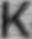

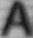

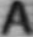

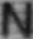

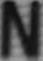

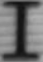

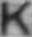

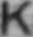

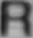

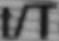

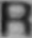

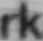

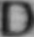

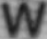

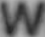

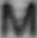

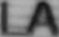

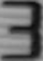

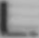

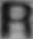

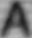

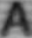

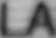

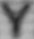

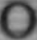

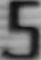

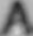

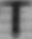

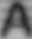

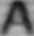

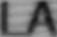

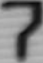

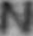

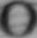

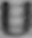

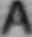

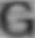

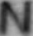

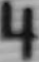

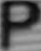

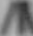

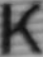

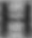

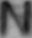

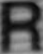

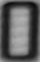

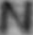

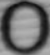

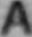

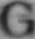

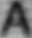

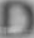

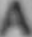

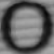

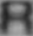

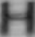

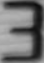

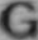

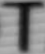

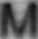

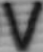

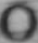

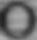

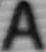

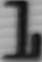

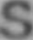

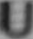

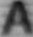

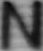

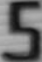

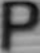

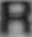

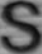

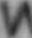

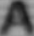

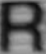

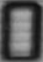

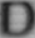

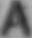

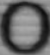

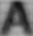

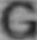

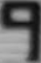

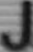

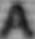

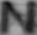

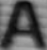

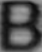

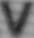

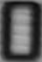

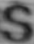

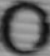

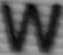

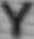

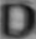

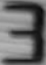

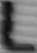

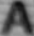

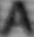

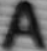

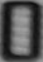

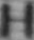

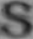

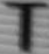

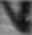

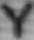

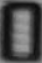

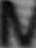

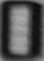

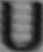

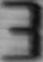

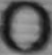

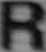

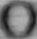

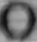

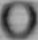

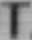

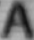

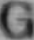

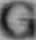

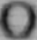

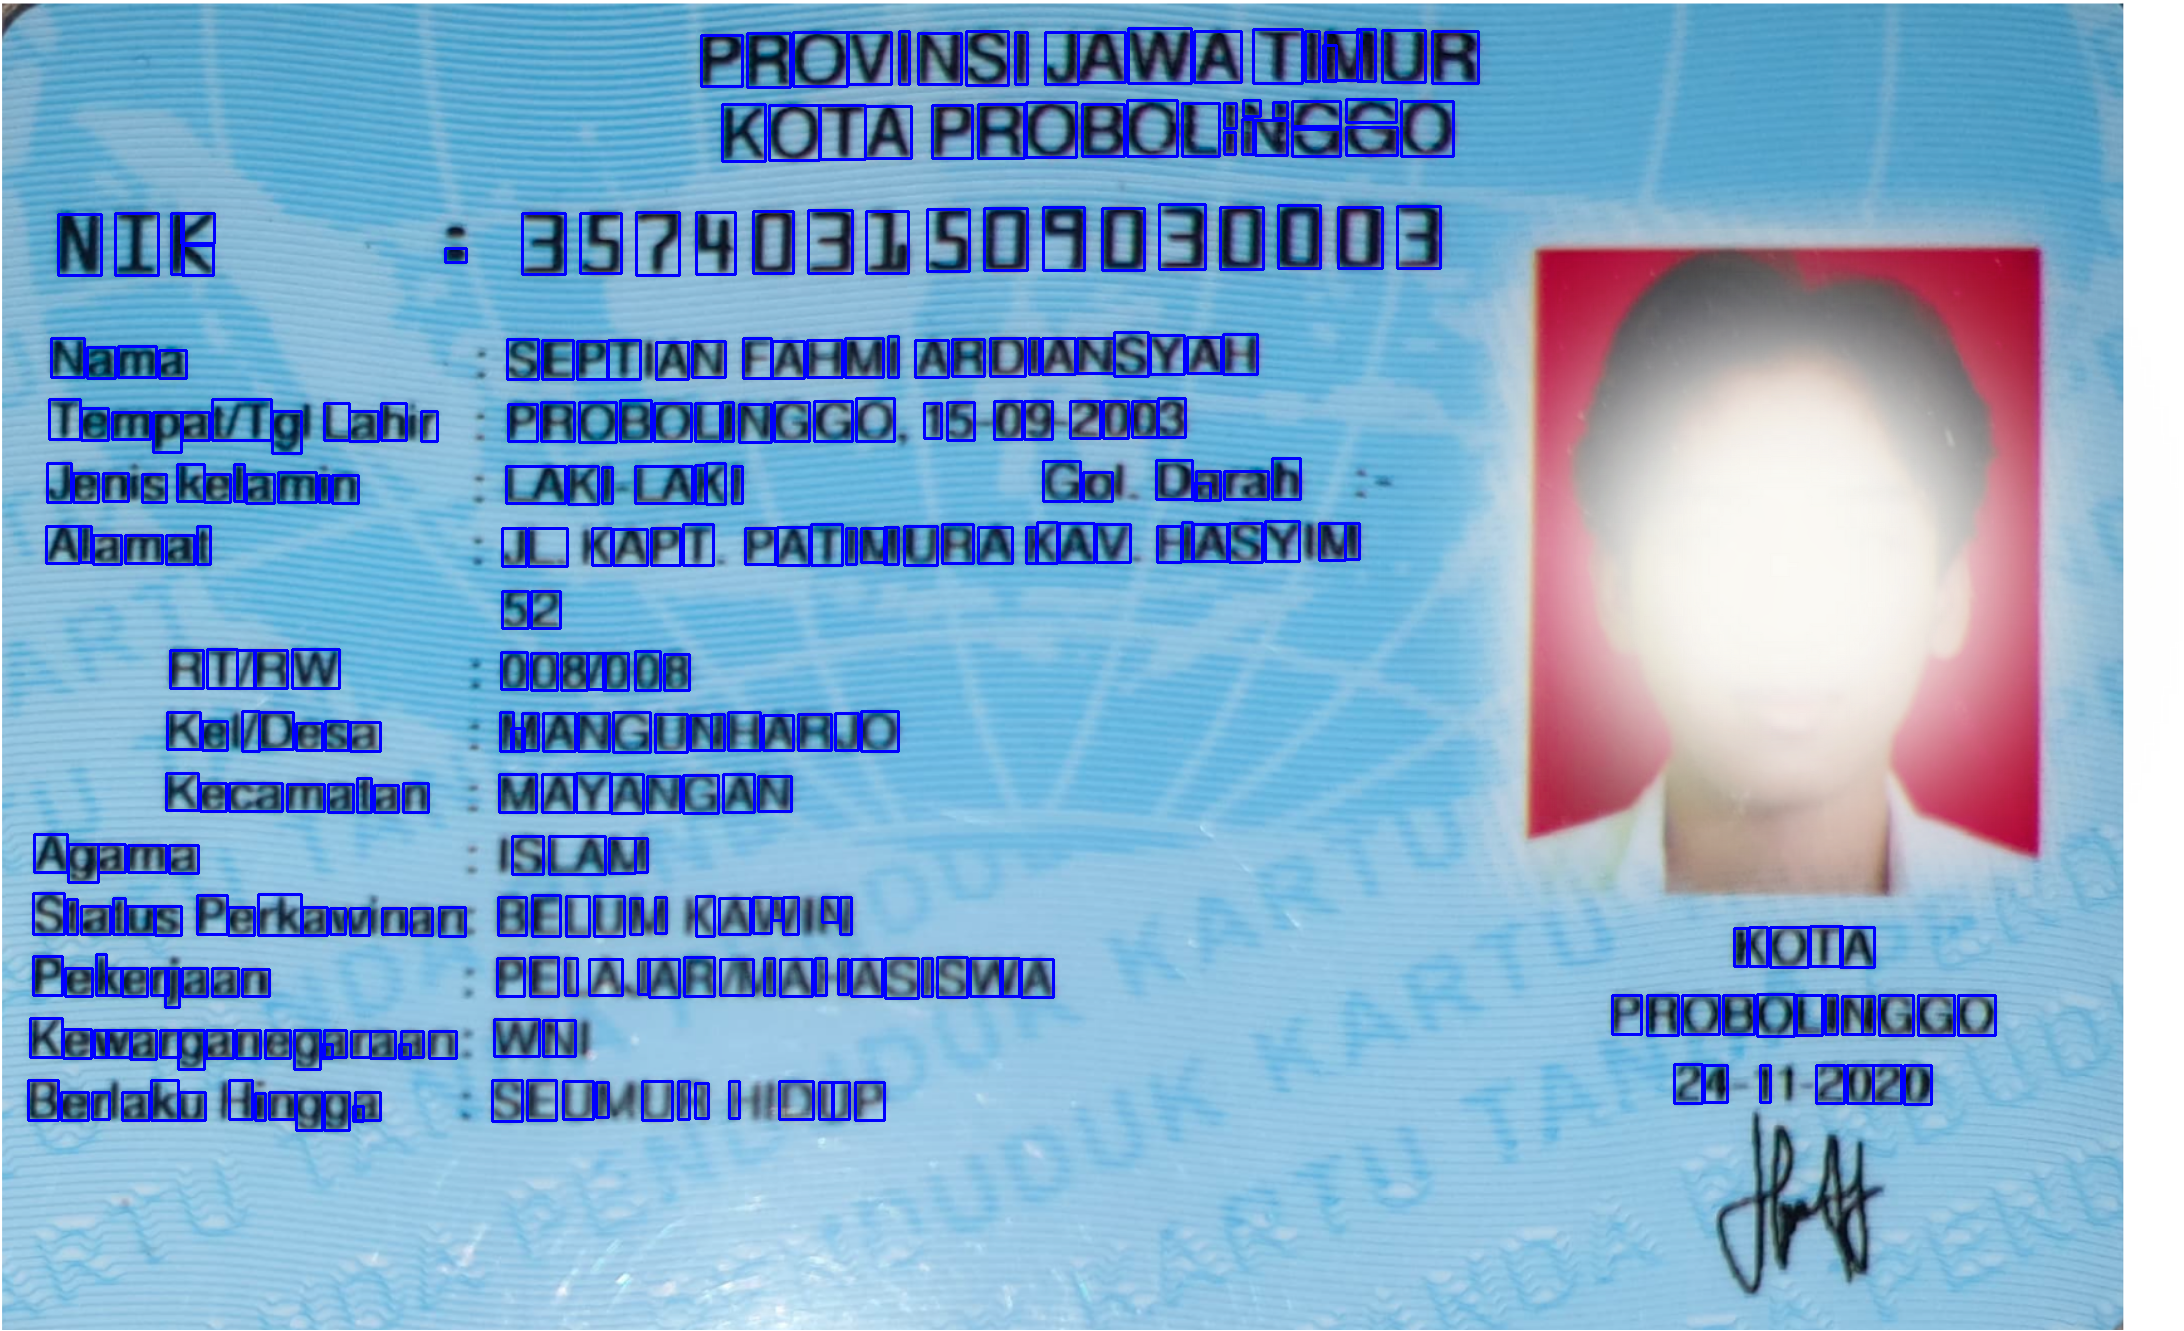

12/12 [==============================] - 0s 21ms/step
B K P S A A J T N N Q R R 1 8 A 1 2 G 2 5 2 U 1 2 R N 8 M 1 I M 2 C M U M 2 S K Y P S 2 Z 1 K 2 K 2 A 1 K D U V 2 2 9 P 1 B B 8 2 T 2 U R H Q 1 D 1 0 1 2 1 A A D A D 9 M M W D 9 A 2 1 B 9 2 L S 2 U D 2 U 2 V 8 2 1 2 2 N 7 9 H R 2 8 D O O S W P B M 1 O 5 J U S P U S A 3 Z L F O Z F A A E 1 A U U 8 U L L K Y P N 0 5 A A 1 U 1 1 0 T N A G A B 1 1 O U 7 1 U N A P 7 1 U A 8 1 G T A A N 1 1 L 1 4 P 1 1 A A 1 K A H 1 1 N F P A U D N A 1 0 4 A G A D A 1 0 A H 3 T C 1 L T A J J 1 1 M 1 V A P 0 0 N A 3 1 S 1 1 U A N 1 1 5 P S A 5 A S H A A D D 0 V 1 A 9 1 0 1 Y A C 9 J A 2 N A B 0 V D 0 S O U D Y D K 3 7 1 L A A C A 2 D H H 1 8 S 1 O T Z Y N B D U O 1 N 1 N U 1 U N 1 U 3 0 R P R 2 0 9 U 1 1 0 1 0 L T 2 1 A A U 1 2 G N G 0 

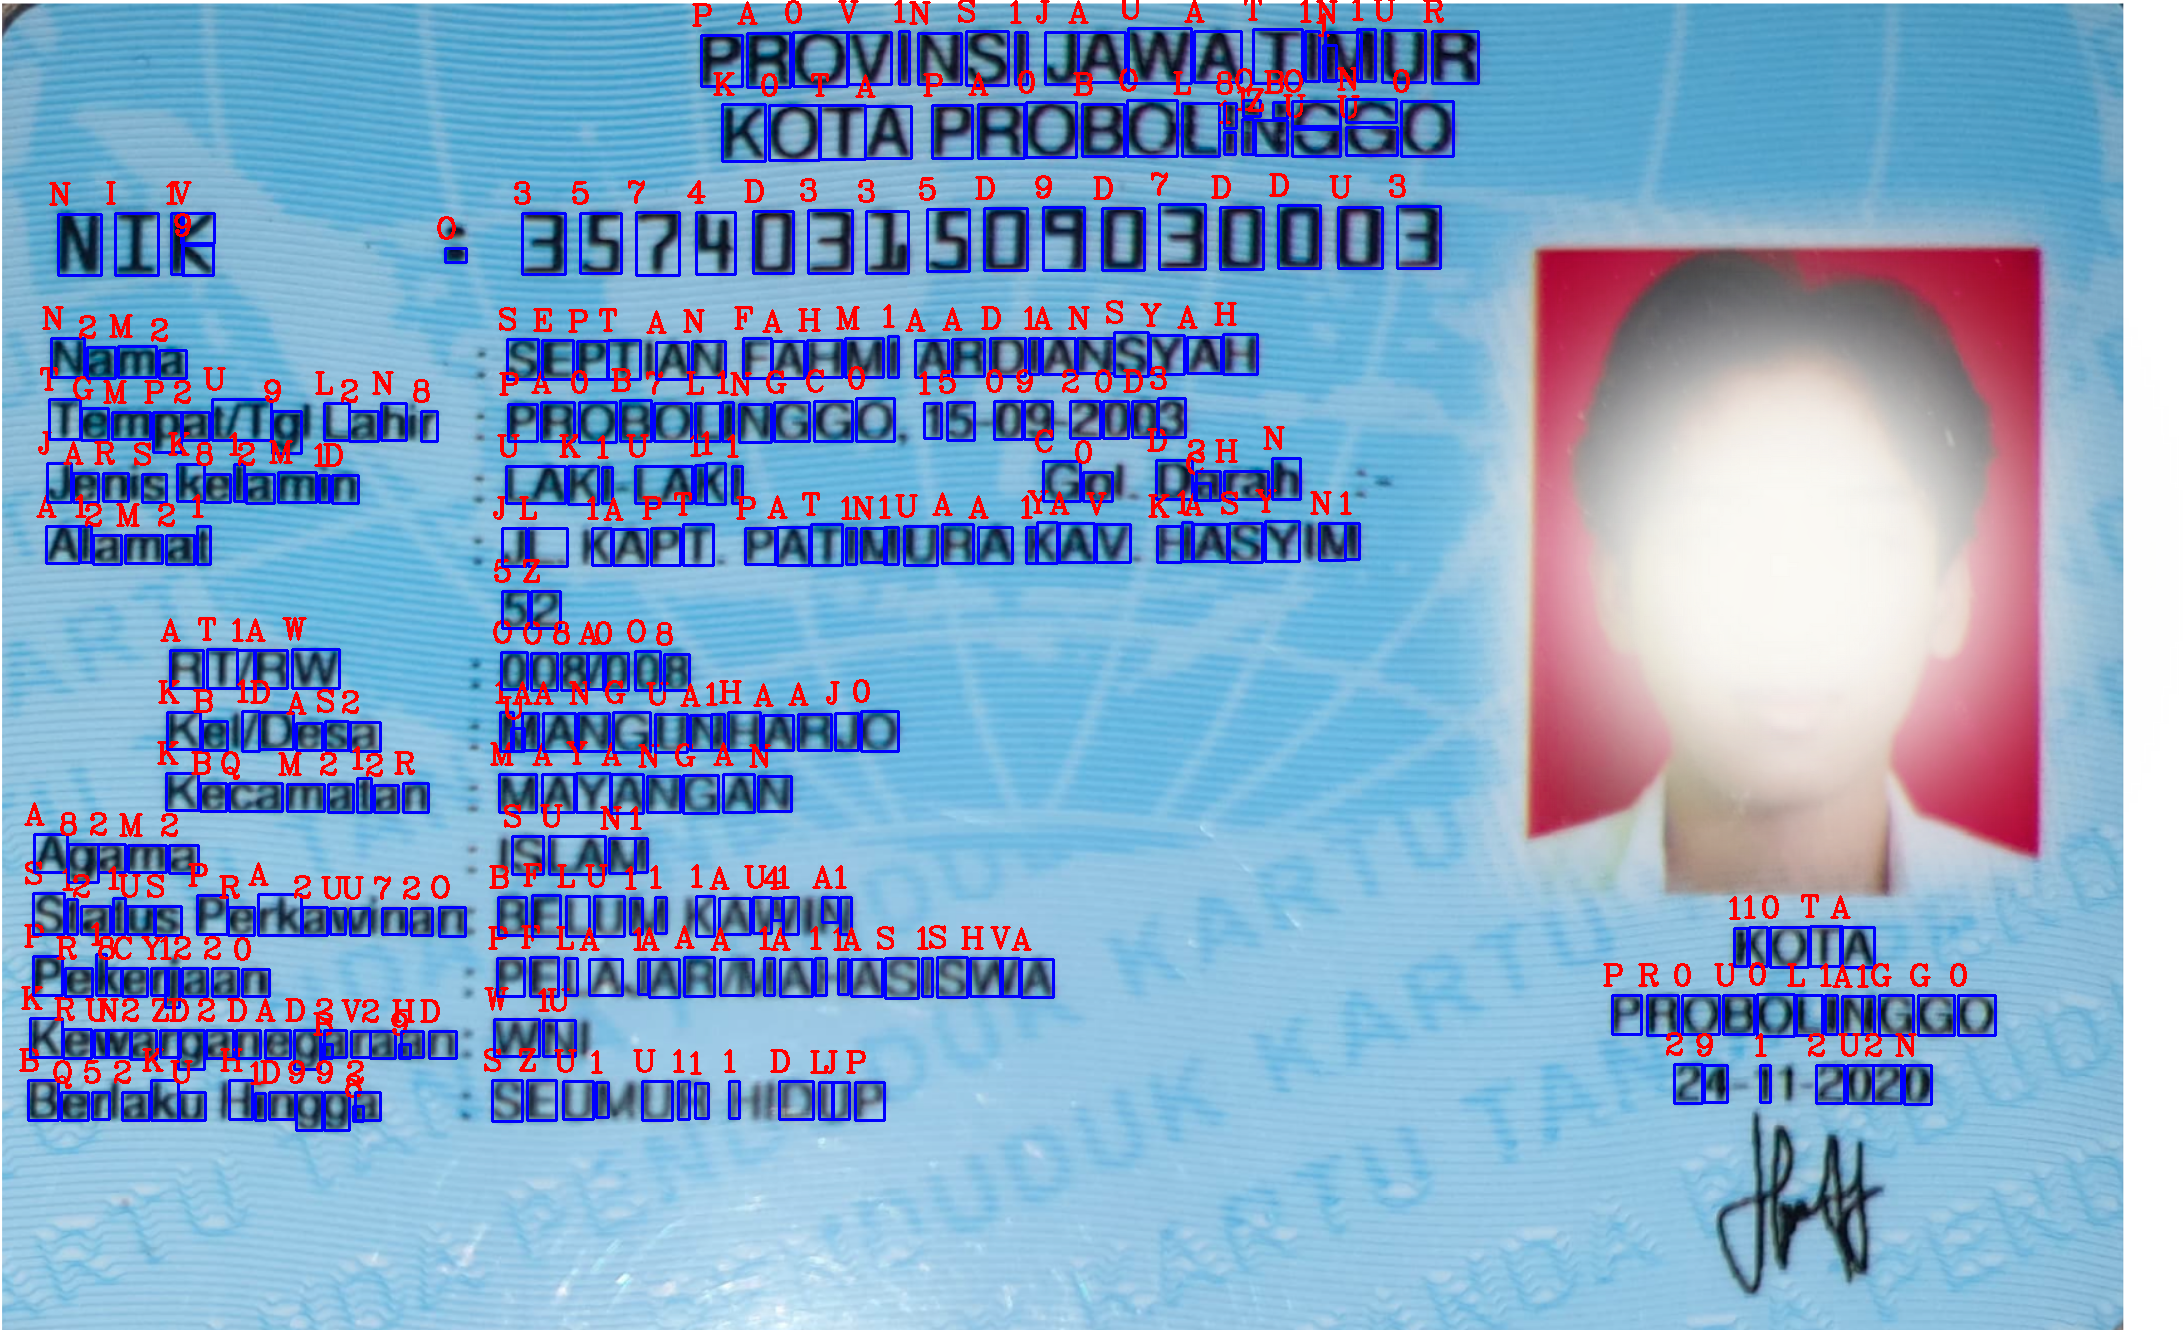

In [36]:
import numpy as np
import imutils
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow

# Load the pre-trained model
network = load_model('/content/network')

# Define function for contour detection
def find_contours(img):
    conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method='left-to-right')[0]

    return conts

# Define function for extracting ROI
def extract_roi(img, x, y, w, h):
    roi = img[y:y+h, x:x+w]
    return roi

# Define function for thresholding
def thresholding(img):
    thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh

# Define function for resizing image
def resize_img(img, w, h):
    if w > h:
        resized = imutils.resize(img, width=28)
    else:
        resized = imutils.resize(img, height=28)

    (h, w) = resized.shape

    dX = int(max(0, 28 - w) / 2.0)
    dY = int(max(0, 28 - h) / 2.0)

    filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    filled = cv2.resize(filled, (28,28))

    return filled

# Define function for normalization
def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Define function for processing bounding box
def process_box(gray, x, y, w, h):
    roi = extract_roi(gray, x, y, w, h)
    thresh = thresholding(roi)
    (h, w) = thresh.shape
    resized = resize_img(thresh, w, h)
    cv2_imshow(resized)
    normalized = normalization(resized)
    return (normalized, (x, y, w, h))

# Read the KTP image
img = cv2.imread('/content/drive/MyDrive/KTP Kelas 3I/18_Septian Fahmi Ardiansyah.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise
blur = cv2.GaussianBlur(gray, (3, 3), 0)

# Apply adaptive thresholding with adjusted parameters
adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 9)

# Invert the image
invertion = 255 - adaptive

# Dilate the image to make characters more prominent
dilation = cv2.dilate(invertion, np.ones((3, 3)))

# Find contours
conts = find_contours(dilation.copy())

# Define min/max width/height for characters
min_w, max_w = 10, 160
min_h, max_h = 14, 140

# Create a copy of the original image for drawing contours
img_copy = img.copy()

# Iterate through contours
for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)

    # Filter contours based on size
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        # Draw bounding box on the original image
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Extract the region of interest (ROI) for the character
        roi = gray[y:y+h, x:x+w]

        # Perform additional processing on the character ROI if needed

        # Display the character ROI
        cv2_imshow(roi)

# Display the original image with bounding boxes
cv2_imshow(img_copy)

# Process each detected character
detected_char = []

for c in conts:
    (x, y, w, h) = cv2.boundingRect(c)

    # Filter contours based on size
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        detected_char.append(process_box(gray, x, y, w, h))

# Get all character pixels
pixels = np.array([px[0] for px in detected_char], dtype='float32')

# Get all bounding boxes for detected characters
boxes = [box[1] for box in detected_char]

# Perform any additional processing or resizing of the character pixels if needed

# Make predictions using the pre-trained model
preds = network.predict(pixels)

# Define the character list
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
char_list = digits + letters
char_list = [ch for ch in char_list]

# Display the predicted characters
for p in preds:
    char_idx = np.argmax(p)
    print(char_list[char_idx], end=" ")

# Display the original image with predicted characters
img_copy2 = img.copy()

for (pred, (x, y, w, h)) in zip(preds, boxes):
    i = np.argmax(pred)
    char_detected = char_list[i]

    cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)

cv2_imshow(img_copy2)
